Import the data

In [42]:
import pandas as pd
import numpy as np

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',
        'CombinedAuthorities': 'string'
    }
)

df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2,3,-9,-9,-9,...,4,-9,-9,-9,-9,-9,4,-9,-9,-9
1,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9
2,11,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,1,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,12,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,1,-9,-9,-9,-9,-9,-9,5,-9,-9
4,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,4,-9,-9,-9,-9,-9,-9,-9,-9,-9


In [43]:
# Define what counts as "missing" for the summary
special_missing_codes = [-8]

# Create a mask: True if NaN OR special code
missing_mask = df.isna() | df.isin(special_missing_codes)

# Count missing values
missing_counts = missing_mask.sum()

# Calculate percentage
missing_percent = (missing_counts / len(df)) * 100

# Combine into a summary table and sort
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

# Show top 10 only
top10_missing = missing_data_summary.head(10)

top10_missing

,Missing Count,Missing %
GRSSWK,28924,8.47
NETWK,27105,7.94
RELIG11,20828,6.1
REDUND,5336,1.56
PAIDHRU,3122,0.91
DIFFHR20,3092,0.91
TTUSHR,3026,0.89
BUSHR,2469,0.72
CONMON,2294,0.67
BANDN,2222,0.65


In [44]:
# Step 1: Define the wellbeing columns
wellbeing_items = ['SATIS', 'WORTH', 'HAPPY']

# Step 2: Drop rows where all three are invalid (-8 or -9)
invalid_mask = (df[wellbeing_items] <= -8).all(axis=1)
df = df[~invalid_mask].copy()

# Step 3: Replace -8 and -9 with NaN temporarily to compute column means
temp = df[wellbeing_items].replace({-8: np.nan, -9: np.nan})

# Step 4: Compute column means (excluding -8/-9)
col_means = temp.mean()

# Print the column means
print("\nColumn means (excluding -8 and -9):")
print(col_means)

# Step 5: Replace -8 and -9 with their respective column means
for col in wellbeing_items:
    df[col] = df[col].replace({-8: col_means[col], -9: col_means[col]})

# Step 6: Compute Wellbeing score as row-wise average
df['Wellbeing'] = df[wellbeing_items].mean(axis=1)

# Optional: Preview
print("\nSample of cleaned data:")
print(df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head())


Column means (excluding -8 and -9):
SATIS    7.553688
WORTH    7.856793
HAPPY    7.509492
dtype: float64

Sample of cleaned data:
   SATIS  WORTH  HAPPY  Wellbeing
0    8.0    8.0    7.0   7.666667
1   10.0    8.0   10.0   9.333333
2   10.0    9.0   10.0   9.666667
4    8.0    5.0    8.0   7.000000
5    8.0    8.0    7.0   7.666667


In [45]:
# Replace missing codes in Wellbeing column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)

def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score < 8:
        return 0   # int, not string
    else:
        return 1

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing).astype('Int64')  

df[['Wellbeing', 'Wellbeing_category']].head()

,Wellbeing,Wellbeing_category
0,7.666667,0
1,9.333333,1
2,9.666667,1
4,7.000000,0
5,7.666667,0


In [46]:
# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype and replace -8 with NaN (keep -9)
df[health_cols] = df[health_cols].astype('Int64')

# Step 3: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 4: Efficient one-pass creation of HEALTH_* columns
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'

    if col_name not in df.columns:
        # Use vectorized comparison and any across the row
        df[col_name] = (df[health_cols] == code).any(axis=1).astype(int)

print("Optimized HEALTH columns created.")

Optimized HEALTH columns created.


In [47]:
# Columns to remove
cols_to_remove = ['GRSSWK', 'NETWK', 'RELIG11', 'SATIS', 'WORTH', 'HAPPY', 'Wellbeing','IDREF']

# Drop the columns
df_filtered = df.drop(columns=cols_to_remove, errors='ignore')

# Define what counts as "missing" for the summary
special_missing_codes = [-8]

# Create a mask: True if NaN OR special code
missing_mask = df_filtered.isna() | df_filtered.isin(special_missing_codes)

# Count missing values
missing_counts = missing_mask.sum()

# Calculate percentage
missing_percent = (missing_counts / len(df_filtered)) * 100

# Combine into a summary table and sort
missing_data_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(2)
}).sort_values(by='Missing Count', ascending=False)

# Show top 10 only
top10_missing = missing_data_summary.head(10)

top10_missing

,Missing Count,Missing %
PAIDHRU,1229,0.71
TTUSHR,1190,0.69
DIFFHR20,1090,0.63
BUSHR,955,0.55
REDUND,848,0.49
DISEA,779,0.45
BANDG,719,0.42
LEFTM,683,0.4
WNLEFT11,588,0.34
WN2LFT11,588,0.34


In [48]:
# Show only categorical columns (object, string, category types)
categorical_cols = df_filtered.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

print("Number of categorical features:", len(categorical_cols))
print("Categorical features:", categorical_cols)

binary_cols = [col for col in df_filtered.columns if df_filtered[col].nunique() == 2]

print("Number of binary features:", len(binary_cols))
print("Binary features:", binary_cols)

Number of categorical features: 15
Categorical features: ['CombinedAuthorities', 'CombinedAuthoritiescensus2021', 'CTRY9D', 'FDSNGDEG', 'GOR9d', 'GOR9dcensus2021', 'ITL221', 'ITL321', 'ITL221census2021', 'ITL321census2021', 'NUTS162', 'NUTS163', 'PARK', 'SNGDEGN', 'SNGHD']
Number of binary features: 39
Binary features: ['BONCMP4', 'ERNCM06', 'GB', 'HALLRES', 'HEALPB2010', 'HRPID', 'ILLDAYS7', 'JB2T103', 'LFSSAMP', 'MARDY6', 'METHAL13', 'METHMP11', 'METHSE6', 'MF1664', 'PENBN133', 'REDP3', 'SEX', 'STUCUR', 'TYPINT', 'UNDY985', 'Wellbeing_category', 'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 'HEALTH_BackOrNeck', 'HEALTH_SeeingDifficulty', 'HEALTH_HearingDifficulty', 'HEALTH_SpeechImpediment', 'HEALTH_Disfigurements', 'HEALTH_BreathingProblems', 'HEALTH_HeartOrCirculation', 'HEALTH_DigestiveOrgans', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety', 'HEALTH_Epilepsy', 'HEALTH_LearningDifficulties', 'HEALTH_MentalIllness', 'HEALTH_ProgressiveIllness', 'HEALTH_OtherProblems', 'HEALTH_Autism']


In [49]:
from sklearn.preprocessing import LabelEncoder

# Copy your dataframe to keep original safe
df_encoded = df_filtered.copy()

# Detect categorical columns
categorical_cols = df_encoded.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

# Exclude 'Wellbeing_category'
categorical_cols = [col for col in categorical_cols if col != 'Wellbeing_category']

print(f"Categorical columns to encode ({len(categorical_cols)}): {categorical_cols}")

# Encode each categorical column separately
for col in categorical_cols:
    le = LabelEncoder()
    # Fill NaN with a placeholder string
    df_encoded[col] = df_encoded[col].fillna('missing').astype(str)
    # Fit and transform to numeric labels
    df_encoded[col] = le.fit_transform(df_encoded[col])

Categorical columns to encode (15): ['CombinedAuthorities', 'CombinedAuthoritiescensus2021', 'CTRY9D', 'FDSNGDEG', 'GOR9d', 'GOR9dcensus2021', 'ITL221', 'ITL321', 'ITL221census2021', 'ITL321census2021', 'NUTS162', 'NUTS163', 'PARK', 'SNGDEGN', 'SNGHD']


In [50]:
# Show data types of each column
print(df_encoded.dtypes)

# Or for a nicer summary with counts per type:
print(df_encoded.dtypes.value_counts())

# If you want to see data types alongside the first few rows:
print(df_encoded.info())

AAGE                             int64
ACTHR                          float64
ACTHR2                         float64
ACTPOT                         float64
ACTUOT                         float64
                                ...   
HEALTH_LearningDifficulties      int64
HEALTH_MentalIllness             int64
HEALTH_ProgressiveIllness        int64
HEALTH_OtherProblems             int64
HEALTH_Autism                    int64
Length: 471, dtype: object
int64      439
float64     20
Int64       12
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 172333 entries, 0 to 341464
Columns: 471 entries, AAGE to HEALTH_Autism
dtypes: Int64(12), float64(20), int64(439)
memory usage: 622.6 MB
None


In [51]:
from sklearn.metrics import normalized_mutual_info_score

# Target column
target = 'Wellbeing_category'

# Make sure target is label-encoded (if not already)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df_encoded[target].astype(str))

# Store results
nmi_scores = {}

for col in df_encoded.columns:
    if col != target:
        nmi = normalized_mutual_info_score(y, df_encoded[col])
        nmi_scores[col] = nmi

# Convert to DataFrame for sorting
nmi_df = pd.DataFrame(list(nmi_scores.items()), columns=['Feature', 'NMI'])
nmi_df = nmi_df.sort_values(by='NMI', ascending=False)

nmi_df.head(20)  

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received binary values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
/opt/ana

,Feature,NMI
14,ANXIOUS,0.059927
318,REDACT,0.019294
238,MARCHK,0.019240
62,DISCURR20,0.019097
214,LIMITK,0.018990
213,LIMITA,0.018655
239,MARDY6,0.018182
63,DISEA,0.017927
212,LIMACT,0.017824
442,XDISDDA20,0.016817


In [52]:
from sklearn.model_selection import train_test_split
# Identify columns with any -8 value
cols_with_minus8 = df_encoded.columns[(df_encoded == -8).any()]

# Drop those columns
df_cleaned = df_encoded.drop(columns=cols_with_minus8)

print(f"Shape after dropping -8 columns: {df_cleaned.shape}")

# Now you can do your train-test-val split on df_cleaned
train_data, temp_data = train_test_split(df_encoded, test_size=0.30, random_state=42, stratify=df_encoded['Wellbeing_category'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, stratify=temp_data['Wellbeing_category'])

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

Shape after dropping -8 columns: (172333, 270)
Train shape: (120633, 471)
Validation shape: (25850, 471)
Test shape: (25850, 471)


In [53]:
print("Train Wellbeing_category distribution:")
print(train_data['Wellbeing_category'].value_counts(normalize=False))

print("\nValidation Wellbeing_category distribution:")
print(val_data['Wellbeing_category'].value_counts(normalize=False))

print("\nTest Wellbeing_category distribution:")
print(test_data['Wellbeing_category'].value_counts(normalize=False))

Train Wellbeing_category distribution:
Wellbeing_category
1    61610
0    59023
Name: count, dtype: Int64

Validation Wellbeing_category distribution:
Wellbeing_category
1    13202
0    12648
Name: count, dtype: Int64

Test Wellbeing_category distribution:
Wellbeing_category
1    13202
0    12648
Name: count, dtype: Int64


In [14]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separate features and target for training
#X_train = train_data.drop(columns=['Wellbeing_category'])
#y_train = train_data['Wellbeing_category']

# Convert features to float for SMOTE
#X_train = X_train.astype(float)

# Initialize SMOTE
#smote = SMOTE(random_state=42)

# Apply SMOTE on training data only
#X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#print(f"Original training shape: {X_train.shape}, {y_train.shape}")
#print(f"Resampled training shape: {X_train_res.shape}, {y_train_res.shape}")

Training Accuracy: 1.0
Training Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     59023
         1.0       1.00      1.00      1.00     61610

    accuracy                           1.00    120633
   macro avg       1.00      1.00      1.00    120633
weighted avg       1.00      1.00      1.00    120633



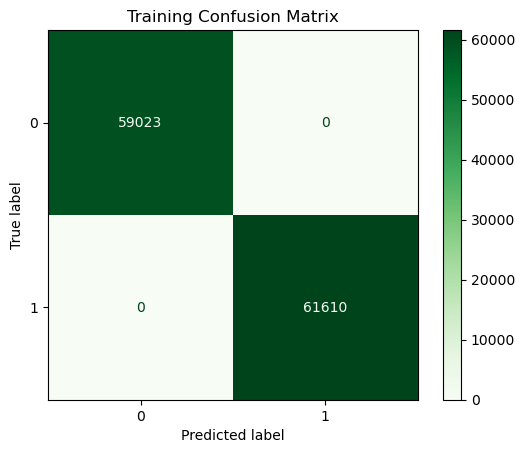

Training AUC-ROC: 1.0000
Validation Accuracy: 0.6831334622823985
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.67      0.67     12648
         1.0       0.69      0.70      0.69     13202

    accuracy                           0.68     25850
   macro avg       0.68      0.68      0.68     25850
weighted avg       0.68      0.68      0.68     25850



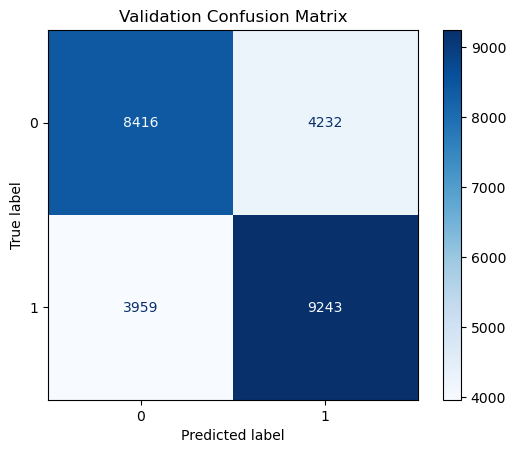

Validation AUC-ROC: 0.7435
Test Accuracy: 0.6858413926499033
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.67      0.68     12648
         1.0       0.69      0.70      0.69     13202

    accuracy                           0.69     25850
   macro avg       0.69      0.69      0.69     25850
weighted avg       0.69      0.69      0.69     25850



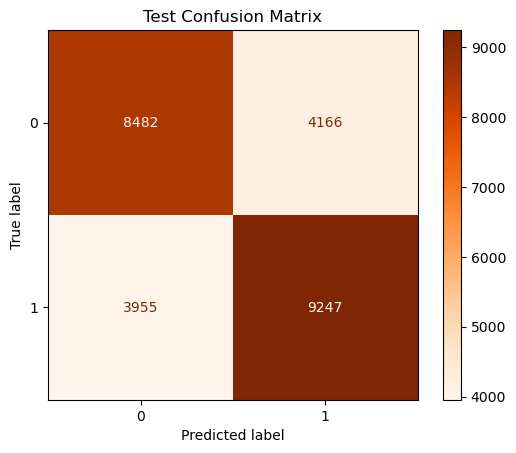

Test AUC-ROC: 0.7467


In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Separate features and target
X_train = train_data.drop(columns=['Wellbeing_category'])
y_train = train_data['Wellbeing_category']

X_val = val_data.drop(columns=['Wellbeing_category'])
y_val = val_data['Wellbeing_category']

X_test = test_data.drop(columns=['Wellbeing_category'])
y_test = test_data['Wellbeing_category']

# Initialize the model
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train on training data
rf_clf.fit(X_train, y_train)

# ---------------------------
# Training performance
# ---------------------------
train_preds = rf_clf.predict(X_train)
train_probs = rf_clf.predict_proba(X_train)[:, 1]

print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Training Classification Report:")
print(classification_report(y_train, train_preds))

cm_train = confusion_matrix(y_train, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
disp_train.plot(cmap=plt.cm.Greens)
plt.title("Training Confusion Matrix")
plt.show()

auc_train = roc_auc_score(y_train, train_probs)
print(f"Training AUC-ROC: {auc_train:.4f}")

# ---------------------------
# Validation performance
# ---------------------------
val_preds = rf_clf.predict(X_val)
val_probs = rf_clf.predict_proba(X_val)[:, 1]

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Validation Classification Report:")
print(classification_report(y_val, val_preds))

cm_val = confusion_matrix(y_val, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp_val.plot(cmap=plt.cm.Blues)
plt.title("Validation Confusion Matrix")
plt.show()

auc_val = roc_auc_score(y_val, val_probs)
print(f"Validation AUC-ROC: {auc_val:.4f}")

# ---------------------------
# Test performance
# ---------------------------
test_preds = rf_clf.predict(X_test)
test_probs = rf_clf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, test_preds))
print("Test Classification Report:")
print(classification_report(y_test, test_preds))

cm_test = confusion_matrix(y_test, test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(cmap=plt.cm.Oranges)
plt.title("Test Confusion Matrix")
plt.show()

auc_test = roc_auc_score(y_test, test_probs)
print(f"Test AUC-ROC: {auc_test:.4f}")

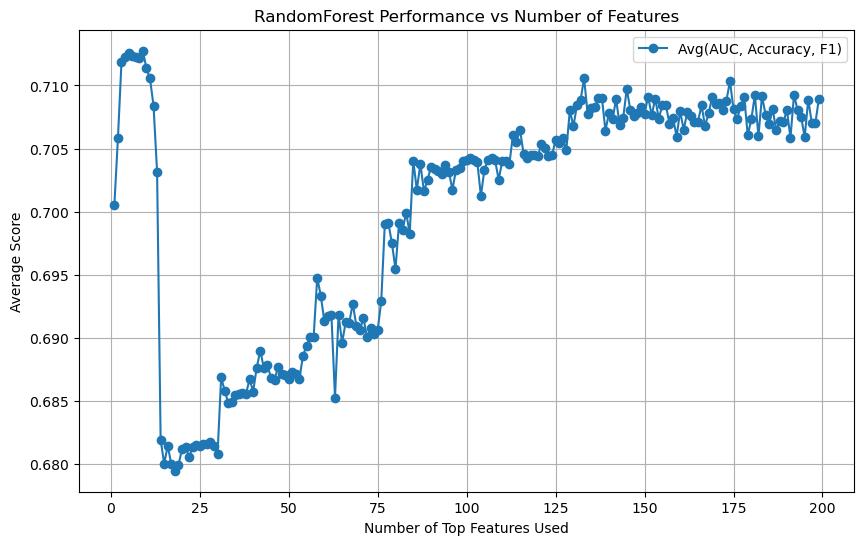

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Features
X_train_all = train_data.drop(columns=['Wellbeing_category'])
X_val_all = val_data.drop(columns=['Wellbeing_category'])

# We'll loop based on your sorted NMI DataFrame
feature_order = nmi_df['Feature'].tolist()

results = []

for k in range(1, min(200, len(feature_order) + 1)):  # Number of features
    top_features = feature_order[:k]
    
    X_train_k = X_train_all[top_features]
    X_val_k = X_val_all[top_features]
    
    # Train RF
    rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    rf.fit(X_train_k, y_train)
    
    # Predictions & probabilities
    val_preds = rf.predict(X_val_k)
    val_probs = rf.predict_proba(X_val_k)
    
    # Handle multi-class AUC
    if len(np.unique(y_train)) > 2:
        auc = roc_auc_score(y_val, val_probs, multi_class='ovr')
    else:
        auc = roc_auc_score(y_val, val_probs[:, 1])
    
    acc = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds, average='weighted')
    
    avg_score = np.mean([auc, acc, f1])
    results.append((k, auc, acc, f1, avg_score))

# Convert results to array for plotting
results = np.array(results)
ks = results[:, 0]
avg_scores = results[:, 4]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ks, avg_scores, marker='o', label='Avg(AUC, Accuracy, F1)')
plt.xlabel('Number of Top Features Used')
plt.ylabel('Average Score')
plt.title('RandomForest Performance vs Number of Features')
plt.grid(True)
plt.legend()
plt.show()

In [61]:
# Sort results by average score in descending order
sorted_results = sorted(results, key=lambda x: x[4], reverse=True)

print("Top 10 feature counts by average score:\n")
for rank, (k, auc, acc, f1, avg) in enumerate(sorted_results[:10], start=1):
    print(f"{rank}. Features: {int(k):3d} | Avg Score: {avg:.4f} | "
          f"AUC: {auc:.4f} | ACC: {acc:.4f} | F1: {f1:.4f}")

Top 10 feature counts by average score:

1. Features:   9 | Avg Score: 0.7127 | AUC: 0.7526 | ACC: 0.6929 | F1: 0.6928
2. Features:   5 | Avg Score: 0.7126 | AUC: 0.7517 | ACC: 0.6930 | F1: 0.6930
3. Features:   6 | Avg Score: 0.7123 | AUC: 0.7516 | ACC: 0.6927 | F1: 0.6926
4. Features:   7 | Avg Score: 0.7123 | AUC: 0.7514 | ACC: 0.6928 | F1: 0.6927
5. Features:   4 | Avg Score: 0.7122 | AUC: 0.7513 | ACC: 0.6928 | F1: 0.6926
6. Features:   8 | Avg Score: 0.7121 | AUC: 0.7512 | ACC: 0.6926 | F1: 0.6925
7. Features:   3 | Avg Score: 0.7119 | AUC: 0.7510 | ACC: 0.6925 | F1: 0.6921
8. Features:  10 | Avg Score: 0.7114 | AUC: 0.7508 | ACC: 0.6916 | F1: 0.6916
9. Features: 133 | Avg Score: 0.7106 | AUC: 0.7497 | ACC: 0.6910 | F1: 0.6910
10. Features:  11 | Avg Score: 0.7105 | AUC: 0.7490 | ACC: 0.6913 | F1: 0.6913



=== Random Forest ===
AUC-ROC: 0.7493
Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68     12648
         1.0       0.70      0.69      0.69     13202

    accuracy                           0.69     25850
   macro avg       0.69      0.69      0.69     25850
weighted avg       0.69      0.69      0.69     25850



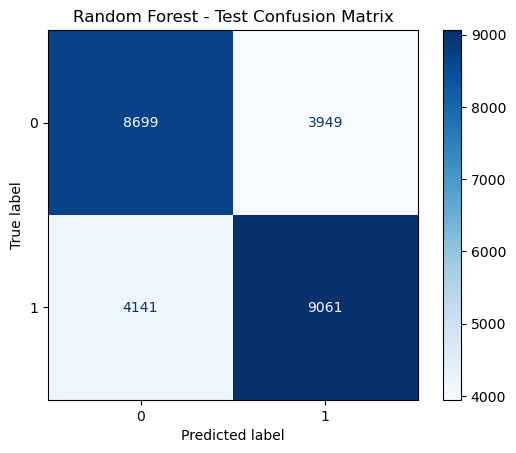


=== XGBoost ===
AUC-ROC: 0.7646
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69     12648
         1.0       0.71      0.70      0.70     13202

    accuracy                           0.70     25850
   macro avg       0.70      0.70      0.70     25850
weighted avg       0.70      0.70      0.70     25850



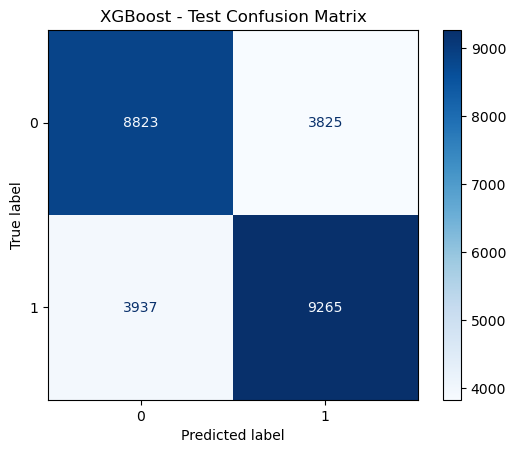


=== Ridge Classifier ===
AUC-ROC: 0.7535
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.63      0.66     12648
         1.0       0.68      0.75      0.71     13202

    accuracy                           0.69     25850
   macro avg       0.69      0.69      0.69     25850
weighted avg       0.69      0.69      0.69     25850



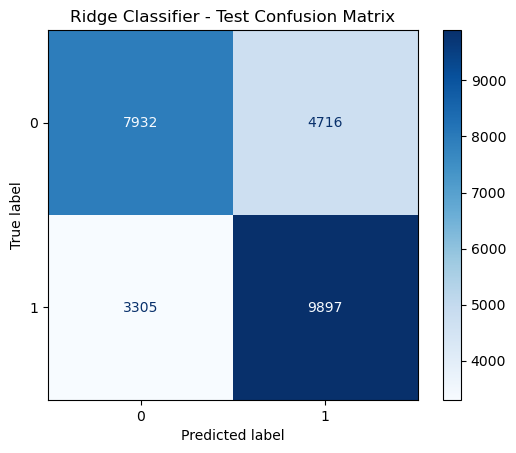


=== Logistic Regression ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC-ROC: 0.7529
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.64      0.67     12648
         1.0       0.68      0.74      0.71     13202

    accuracy                           0.69     25850
   macro avg       0.69      0.69      0.69     25850
weighted avg       0.69      0.69      0.69     25850



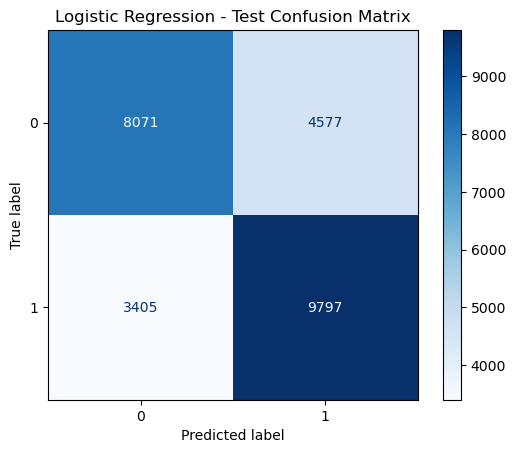


=== Linear SVM ===
AUC-ROC: 0.7536
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67     12648
         1.0       0.68      0.75      0.71     13202

    accuracy                           0.69     25850
   macro avg       0.69      0.69      0.69     25850
weighted avg       0.69      0.69      0.69     25850



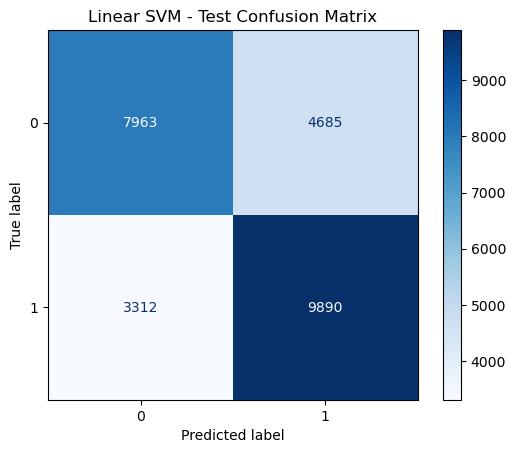


=== KNN ===
AUC-ROC: 0.5433
Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51     12648
         1.0       0.54      0.56      0.55     13202

    accuracy                           0.53     25850
   macro avg       0.53      0.53      0.53     25850
weighted avg       0.53      0.53      0.53     25850



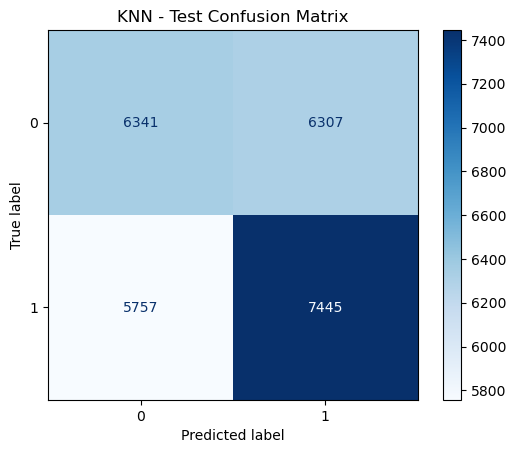

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Select top MI features
top_features_10 = nmi_df['Feature'].head(133).tolist()

# Only use top 10 features
X_train = train_data[top_features_10]
X_test = test_data[top_features_10]

models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42, n_jobs=-1),
    "Linear SVM": LinearSVC(dual='auto', random_state=42, max_iter=5000),
    "KNN": KNeighborsClassifier()
}

for name, model in models.items():
    print(f"\n=== {name} ===")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # Probabilities for AUC (if available)
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
    else:
        # For models like LinearSVC, use decision_function
        if hasattr(model, "decision_function"):
            decision_vals = model.decision_function(X_test)
            if decision_vals.ndim == 1:  # binary
                probs = np.vstack([1 - decision_vals, decision_vals]).T
            else:
                probs = decision_vals
        else:
            probs = None

    # AUC calculation
    if probs is not None:
        if len(np.unique(y_train)) > 2:
            auc = roc_auc_score(y_test, probs, multi_class='ovr')
        else:
            auc = roc_auc_score(y_test, probs[:, 1])
        print(f"AUC-ROC: {auc:.4f}")
    else:
        print("AUC-ROC: Not available for this model (no probability output)")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Test Confusion Matrix")
    plt.show()

In [80]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

summary_results = []

for name, model in models.items():
    preds = model.predict(X_test)

    # Probabilities or decision values
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        decision_vals = model.decision_function(X_test)
        if decision_vals.ndim == 1:  # binary
            probs = np.vstack([1 - decision_vals, decision_vals]).T
        else:
            probs = decision_vals
    else:
        probs = None

    # AUC
    if probs is not None:
        if len(np.unique(y_train)) > 2:
            auc = roc_auc_score(y_test, probs, multi_class='ovr')
        else:
            auc = roc_auc_score(y_test, probs[:, 1])
    else:
        auc = np.nan

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')

    summary_results.append([name, acc, f1, auc])

# DataFrame
summary_df = pd.DataFrame(summary_results, columns=["Model", "Test Accuracy", "Test F1", "Test ROC AUC"])
summary_df = summary_df.sort_values(by="Test ROC AUC", ascending=False)

print("\n=== Model Performance Summary (Test Data Only) ===")
print(summary_df.reset_index(drop=True))


=== Model Performance Summary (Test Data Only) ===
                 Model  Test Accuracy   Test F1  Test ROC AUC
0              XGBoost       0.699729  0.699751      0.764618
1           Linear SVM       0.690638  0.689407      0.753590
2     Ridge Classifier       0.689710  0.688415      0.753527
3  Logistic Regression       0.691219  0.690280      0.752913
4        Random Forest       0.687041  0.687073      0.749342
5                  KNN       0.533308  0.532883      0.543328


In [94]:
def check_wellbeing_category(data):
    col = data['Wellbeing_category']
    print(f"Type: {type(col)}")
    print(f"Shape: {getattr(col, 'shape', 'N/A')}")
    if hasattr(col, 'ndim'):
        if col.ndim == 1:
            print("Wellbeing_category is 1D")
        else:
            print(f"Wellbeing_category is {col.ndim}D")
    else:
        print("Cannot determine ndim")
    unique_vals = np.unique(col)
    print(f"Unique values in Wellbeing_category: {unique_vals}")

# Usage example:
check_wellbeing_category(train_data)
check_wellbeing_category(test_data)

Type: <class 'pandas.core.series.Series'>
Shape: (120633,)
Wellbeing_category is 1D
Unique values in Wellbeing_category: [0 1]
Type: <class 'pandas.core.series.Series'>
Shape: (25850,)
Wellbeing_category is 1D
Unique values in Wellbeing_category: [0 1]


In [96]:
def check_y(y, name="y"):
    print(f"Checking {name}:")
    print(f"  Shape: {y.shape}")
    print(f"  Type: {type(y)}")
    print(f"  Dtype: {y.dtype}")
    if len(y.shape) == 1:
        print(f"  Seems flat (1D) array with unique values: {np.unique(y)}")
    elif len(y.shape) == 2:
        print(f"  Seems 2D array. Shape: {y.shape}")
        unique_vals = np.unique(y)
        print(f"  Unique values (first 10): {unique_vals[:10]}")
        # Check if it looks like one-hot (only 0 and 1, and sums along axis=1 are 1)
        row_sums = np.sum(y, axis=1)
        if np.all((unique_vals == 0) | (unique_vals == 1)) and np.allclose(row_sums, 1):
            print("  Looks like one-hot encoded labels!")
        else:
            print("  Does not look like one-hot, but is 2D.")
    else:
        print("  Unexpected shape!")

# Example usage:
check_y(y_train, "y_train")
check_y(y_test, "y_test")

Checking y_train:
  Shape: (120633,)
  Type: <class 'pandas.core.series.Series'>
  Dtype: Int64
  Seems flat (1D) array with unique values: [0 1]
Checking y_test:
  Shape: (25850,)
  Type: <class 'pandas.core.series.Series'>
  Dtype: Int64
  Seems flat (1D) array with unique values: [0 1]


In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np

# Ensure y_test is 1D integer labels
if len(y_test.shape) == 2 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test

# Define parameter grids 
param_grids = {
    "XGBoost": {
        'n_estimators': [200, 500],
        'max_depth': [3],
        'learning_rate': [0.05],
        'subsample': [0.8],
        'colsample_bytree': [1.0]
    },
    "Linear SVM": {
        'svm__C': [0.1, 1.0],
        'svm__class_weight': [None]
    },
    "Ridge Classifier": {
        'alpha': [0.1, 1.0],
        'class_weight': [None]
    },
    "Logistic Regression": {
        'logreg__C': [0.1, 1.0],
        'logreg__solver': ['lbfgs'],
        'logreg__class_weight': [None]
    }
}

# Models
models = {
    "XGBoost": XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss'),
    "Linear SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('svm', LinearSVC(dual='auto', max_iter=5000, random_state=42))
    ]),
    "Ridge Classifier": RidgeClassifier(random_state=42),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ])
}

# Scoring mapping
scoring_map = {
    "XGBoost": 'roc_auc_ovr',
    "Logistic Regression": 'roc_auc_ovr',
    "Linear SVM": 'f1_weighted',
    "Ridge Classifier": 'f1_weighted'
}

# Store results
results = []

# Loop through models
for name, model in models.items():
    print(f"\n=== Tuning {name} ===")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring=scoring_map[name],
        cv=3,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    print(f"Best params for {name}: {grid.best_params_}")
    best_model = grid.best_estimator_

    # Predictions
    preds = best_model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test_labels, preds)
    f1 = f1_score(y_test_labels, preds, average='weighted')

    # ROC AUC handling for binary/multiclass
    try:
        auc = None
        if hasattr(best_model, "predict_proba"):
            probs = best_model.predict_proba(X_test)
            if probs.shape[1] == 2:  # Binary classification
                auc = roc_auc_score(y_test_labels, probs[:, 1])
            else:  # Multiclass classification
                auc = roc_auc_score(y_test_labels, probs, multi_class='ovr', average='macro')
        elif hasattr(best_model, "decision_function"):
            scores = best_model.decision_function(X_test)
            if scores.ndim == 1:  # Binary classification
                auc = roc_auc_score(y_test_labels, scores)
            else:  # Multiclass classification
                auc = roc_auc_score(y_test_labels, scores, multi_class='ovr', average='macro')
    except Exception as e:
        print(f"AUC calculation failed for {name}: {e}")

    results.append({
        "Model": name,
        "Test Accuracy": acc,
        "Test F1": f1,
        "Test ROC AUC": auc
    })

# Convert to DataFrame for summary
results_df = pd.DataFrame(results)
print("\n=== Final Model Performance (Test Set) ===")
print(results_df)


=== Tuning XGBoost ===
Best params for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}

=== Tuning Linear SVM ===
Best params for Linear SVM: {'svm__C': 1.0, 'svm__class_weight': None}

=== Tuning Ridge Classifier ===
Best params for Ridge Classifier: {'alpha': 1.0, 'class_weight': None}

=== Tuning Logistic Regression ===
Best params for Logistic Regression: {'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__solver': 'lbfgs'}

=== Final Model Performance (Test Set) ===
                 Model  Test Accuracy   Test F1  Test ROC AUC
0              XGBoost       0.703675  0.703707      0.771015
1           Linear SVM       0.689981  0.688739      0.753525
2     Ridge Classifier       0.689710  0.688415      0.753527
3  Logistic Regression       0.690832  0.689883      0.753387
